In [69]:
import os
import re
import datetime

import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.externals import joblib
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [171]:
data = pd.read_csv('out.csv', nrows=500000)

In [21]:
data.head()

,key,is_purchase,status,company,premium,sum,action_type,is_partner,created_at,init_from,...,place,is_foreigner,sports,adult,child,ip,referer,user_agent,timezone,is_adblock_enabled
0,4601,True,SENT,RES,417.6,300000.0,ALWAYS,False,1559590087,2019-06-09,...,NaN,False,SHESTOVAYA-AKROBATIKA--POLDENS-POLE-DANCE-PILON-,1,0,213.87.128.216,https://prosto.insure/sportivnaja-strakhovka/s...,Mozilla/5.0 (Linux; Android 8.0.0; VTR-L29) Ap...,180.0,False
1,4601,True,CALCULATE,RES,417.6,300000.0,ALWAYS,False,1559589752,2019-06-09,...,NaN,False,SHESTOVAYA-AKROBATIKA--POLDENS-POLE-DANCE-PILON-,1,0,213.87.128.216,https://prosto.insure/sportivnaja-strakhovka/s...,Mozilla/5.0 (Linux; Android 8.0.0; VTR-L29) Ap...,180.0,False
2,4601,True,CALCULATE,RES,417.6,300000.0,ALWAYS,False,1559589752,2019-06-09,...,NaN,False,SHESTOVAYA-AKROBATIKA--POLDENS-POLE-DANCE-PILON-,1,0,213.87.128.216,https://prosto.insure/sportivnaja-strakhovka/s...,Mozilla/5.0 (Linux; Android 8.0.0; VTR-L29) Ap...,180.0,False
3,4601,True,CALCULATE,VTB,874.0,300000.0,ALWAYS,False,1559589752,2019-06-09,...,NaN,False,SHESTOVAYA-AKROBATIKA--POLDENS-POLE-DANCE-PILON-,1,0,213.87.128.216,https://prosto.insure/sportivnaja-strakhovka/s...,Mozilla/5.0 (Linux; Android 8.0.0; VTR-L29) Ap...,180.0,False
4,4601,True,CALCULATE,ZET,810.0,300000.0,ALWAYS,False,1559589752,2019-06-09,...,NaN,False,SHESTOVAYA-AKROBATIKA--POLDENS-POLE-DANCE-PILON-,1,0,213.87.128.216,https://prosto.insure/sportivnaja-strakhovka/s...,Mozilla/5.0 (Linux; Android 8.0.0; VTR-L29) Ap...,180.0,False


In [ ]:
def correlation_plot(data):
    
    data = data.drop(['key', 'created_at', 'init_from', 'init_till', 'year', 'place', 'timezone', 'is_adblock_enabled', 'ip'], axis=1)
    
    sns.pairplot(data)

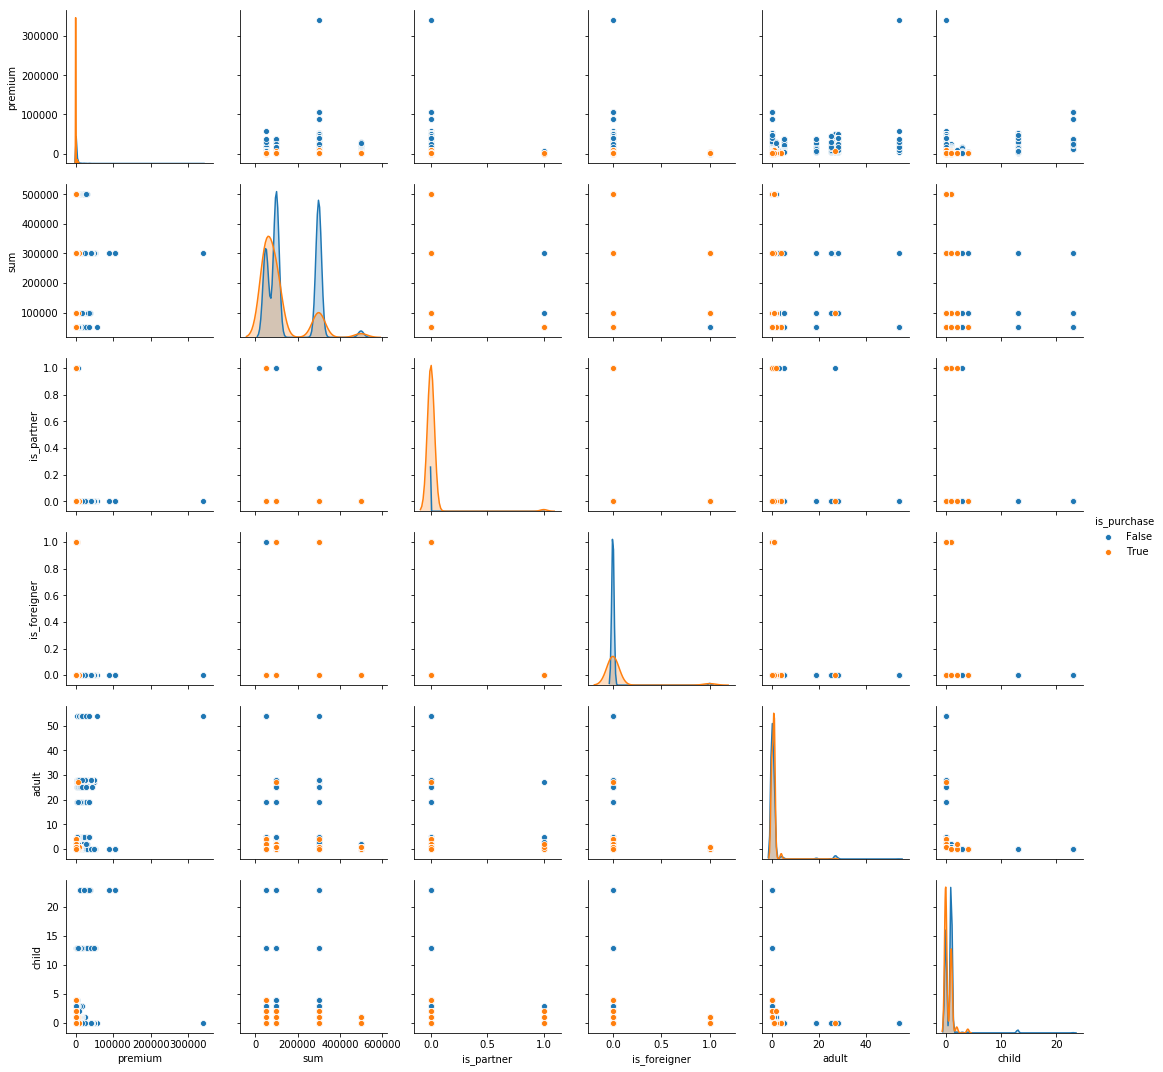

In [5]:
plt = sns.pairplot(data, x_vars=['premium', 'sum', 'is_partner', 'is_foreigner', 'adult', 'child'],
                        y_vars=['premium', 'sum', 'is_partner', 'is_foreigner', 'adult', 'child'], hue='is_purchase')

In [11]:
def plot_user_agents(data):
    
    data = data.drop_duplicates(['key']).reset_index(drop=True)
    data['is_purchase'] = data['is_purchase'].map(lambda x: 1 if x == True else 0)
    data['not_purchase'] = data['is_purchase'].map(lambda x: 0 if x == True else 1)
    
    data['user_agent'] = data['user_agent'].map(lambda agent: \
        'Android' if re.search('Android', str(agent)) else \
        'iPhone' if re.search('iPhone', str(agent)) else \
        'Macintosh' if re.search('Macintosh', str(agent)) else \
        'Windows' if re.search('Windows', str(agent)) else \
        'Others'
    )
    
    data[data['is_purchase'] == 1].groupby('user_agent').agg('sum').plot(ax=axes[0] ,kind='bar', stacked=True, legend=None, color='g', title='Who buys more')
    data.groupby('user_agent').agg('sum')[['is_purchase', 'not_purchase']].plot(ax=axes[1] ,kind='bar', stacked=True, title='Deeper Cut', )

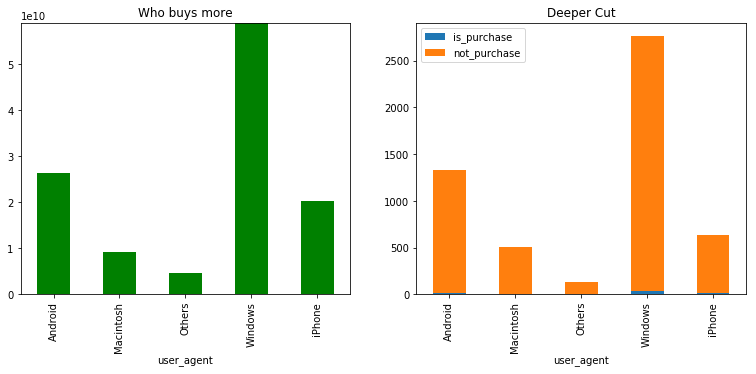

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
plot_user_agents(data)

In [ ]:
def plot_days_and_hours(data):
    pass

## Creating a Masterpiece Pipeline

In [89]:
class CompaniesTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        data__companies = self._find_num_companies(X)
        X = X.drop_duplicates(['key']).reset_index(drop=True)
        X['Num_of_companies'] = data__companies
        X.drop('key', axis=1, inplace=True)
        
        return X
    
    def _find_num_companies(self, data):
        keys = data.key.unique()
        data__companies = []
         
        for key in keys:
            data__companies.append(
                len(data[data['key'] == key].company.unique())
            )
            
        return data__companies

In [90]:
POSSIBLE_COLUMNS = np.load('sport_types.npy')

In [91]:
class SportTransform(BaseEstimator, TransformerMixin):
    
    possible_columns = POSSIBLE_COLUMNS
    
    def fit(self, X, y=None):
        
        sports_dummies = pd.get_dummies(X['sports'], prefix='Sport')
        self.possible_columns = np.concatenate([self.possible_columns, [dummy for dummy in sports_dummies if dummy not in self.possible_columns]])
        
        """
        with open('sport_types.pkl', 'w') as f:
            pickle.dump(self.possible_columns, f)
        """
        
        np.save('sport_types.npy', self.possible_columns)
        
        return self
    
    def transform(self, X, y=None):
        
        sports_dummies = pd.get_dummies(X['sports'], prefix='Sport')
        for column in self.possible_columns:
            if column in sports_dummies.columns:
                X[column] = sports_dummies[column]
            else:
                X[column] = np.zeros(X.shape[0], dtype=np.uint8)
        
        #X = pd.concat([X, sports_dummies], axis=1)
        X.drop('sports', axis=1, inplace=True)
        
        return X

In [92]:
class DurationTransform(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['init_from__days'] = X['init_from'].map(lambda d: int(d.split('-')[2]))
        X['init_from__month'] = X['init_from'].map(lambda w: int(w.split('-')[1]))
        X['init_from__years'] = X['init_from'].map(lambda m: int(m.split('-')[0]))

        X['init_till__days'] = X['init_till'].map(lambda d: int(d.split('-')[2]))
        X['init_till__month'] = X['init_till'].map(lambda w: int(w.split('-')[1]))
        X['init_till__years'] = X['init_till'].map(lambda m: int(m.split('-')[0]))
        
        X['Length'] = (X['init_till__days'] - X['init_from__days']) + \
                        (X['init_till__month'] - X['init_from__month']) * 30 + \
                            (X['init_till__years'] - X['init_from__years']) * 365 + 1
        
        X.drop(['init_from__days', 'init_from__month', \
                   'init_from__years', 'init_till__days', \
                   'init_till__month', 'init_till__years', \
                   'init_from', 'init_till'], axis=1, inplace=True)
        
        X['Short_term'] = X['Length'].map(lambda l: 1 if l < 7 else 0)
        X['Middle_term'] = X['Length'].map(lambda l: 1 if 7 < l < 30  else 0)
        X['Long_term'] = X['Length'].map(lambda l: 1 if 30 < l else 0)
        
        X.drop('Length', axis=1, inplace=True)
        
        return X

In [93]:
class GroupTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['Group_size'] = X['adult'] + X['child']
        
        X['Group_small'] = X['Group_size'].map(lambda x: 1 if x == 1 else 0)
        X['Group_middle'] = X['Group_size'].map(lambda x: 1 if 1 < x < 5 else 0)
        X['Group_large'] = X['Group_size'].map(lambda x: 1 if 10 < x else 0)
        
        X.drop(['Group_size', 'adult', 'child'], axis=1, inplace=True)
        
        return X

In [94]:
"""
Possible OSs:
    - Android
    - iPhone
    - Macintosh
    - Windows
"""

class UserAgentTransform(BaseEstimator, TransformerMixin):
    
    possible_columns = ['User_agent_Android', 'User_agent_Macintosh', \
                'User_agent_Others', 'User_agent_Windows', 'User_agent_iPhone']
    
    def fit(self, X, y=None):
        
        X['user_agent'] = X['user_agent'].map(lambda agent: \
            'Android' if re.search('Android', str(agent)) else \
            'iPhone' if re.search('iPhone', str(agent)) else \
            'Macintosh' if re.search('Macintosh', str(agent)) else \
            'Windows' if re.search('Windows', str(agent)) else \
            'Others'
        )
        
        user_agent_dummies = pd.get_dummies(X['user_agent'], prefix='User_agent')
        self.possible_columns = np.concatenate([self.possible_columns, [dummy for dummy in user_agent_dummies if dummy not in self.possible_columns]])
        
        
        return self
    
    def transform(self, X, y=None):
        
        X['user_agent'] = X['user_agent'].map(lambda agent: \
            'Android' if re.search('Android', str(agent)) else \
            'iPhone' if re.search('iPhone', str(agent)) else \
            'Macintosh' if re.search('Macintosh', str(agent)) else \
            'Windows' if re.search('Windows', str(agent)) else \
            'Others'
        )
        
        user_agent_dummies = pd.get_dummies(X['user_agent'], prefix='User_agent')
        
        for column in self.possible_columns:
            if column in user_agent_dummies.columns:
                X[column] = user_agent_dummies[column]
            else:
                X[column] = np.zeros(X.shape[0], dtype=np.uint8)
        
        #X = pd.concat([X, user_agent_dummies], axis=1)
        X.drop('user_agent', axis=1, inplace=True)
        
        return X

In [95]:
class DropingTransform(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X.drop(['status', 'company', 'year', \
                'place', 'timezone', 'ip', \
                'referer'], axis=1, inplace=True)
        
        return X

In [96]:
class BinaryTransform(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['is_foreigner'] = X['is_foreigner'].map(lambda x: 1 if x == True else 0)
        X['is_adblock_enabled'] = X['is_adblock_enabled'].map(lambda x: 1 if x == True else 0)
        X['action_type'] = X['action_type'].map(lambda x: 1 if x == True else 0)
        X['is_partner'] = X['is_partner'].map(lambda x: 1 if x == True else 0)
        #X['is_purchase'] = X['is_purchase'].map(lambda x: 1 if x == True else 0)
        
        return X

In [121]:
class ScalerTransform(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        scaler = MinMaxScaler()
        X['premium'] = scaler.fit_transform(X['premium'].values.reshape(-1, 1))
        X['sum'] = scaler.fit_transform(X['sum'].values.reshape(-1, 1))
        return X

In [133]:
class TimestampTransform(BaseEstimator, TransformerMixin):
    
    possible_hours = ['Hour_{}'.format(hour) for hour in list(range(0, 24))]
    possible_days = ['Day_{}'.format(day) for day in list(range(0, 7))]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['created_at'] = X['created_at'].map(lambda stamp: datetime.datetime.fromtimestamp(stamp))
        X['weekday'] = X['created_at'].map(lambda date: date.weekday())
        X['hour'] = X['created_at'].map(lambda date: date.hour)
        
        weekday_dummies = pd.get_dummies(X['weekday'], prefix='Day')
        hour_dummies = pd.get_dummies(X['hour'], prefix='Hour')

        for day in possible_days:
            if day in weekday_dummies.columns:
                X[day] = weekday_dummies[day]
            else:
                X[day] = np.zeros(X.shape[0], dtype=np.uint8)

        for hour in possible_hours:
            if hour in hour_dummies.columns:
                X[hour] = hour_dummies[hour]
            else:
                X[hour] = np.zeros(X.shape[0], dtype=np.uint8)
                
        X.drop('created_at', axis=1, inplace=True)

        return X

In [142]:
def split(data, train_size=0.8):
    
    y = data['is_purchase']
    X = data.drop('is_purchase', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    
    return (X_train, X_test, y_train, y_test)

In [148]:
def score(y_test, y_pred):
    
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))

In [172]:
pipeline = Pipeline([
    ('companies', CompaniesTransformer()),
    ('sports', SportTransform()),
    ('duration', DurationTransform()),
    ('group', GroupTransformer()),
    ('user_agent', UserAgentTransform()),
    ('binary', BinaryTransform()),
    ('droping', DropingTransform()),
    ('scaler', ScalerTransform()),
    ('timestamp', TimestampTransform()),
])

In [173]:
data = pipeline.transform(data)

In [177]:
data = data.sample(frac=1).reset_index(drop=True)

In [178]:
(X_train, X_test, y_train, y_test) = split(data)

## Implementing a Great Classifier

In [197]:
clf = SGDClassifier(loss='log'); clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [198]:
y_pred = clf.predict(X_test)

In [200]:
clf.predict_proba(X_test[y_pred == True])[:10]

array([[4.70569437e-01, 5.29430563e-01],
       [3.15783004e-01, 6.84216996e-01],
       [1.92461341e-01, 8.07538659e-01],
       [1.15178684e-01, 8.84821316e-01],
       [2.27825537e-03, 9.97721745e-01],
       [1.80956748e-01, 8.19043252e-01],
       [7.97551656e-04, 9.99202448e-01],
       [1.01260057e-03, 9.98987399e-01],
       [2.65417036e-01, 7.34582964e-01],
       [1.85568071e-02, 9.81443193e-01]])